In [43]:
import tensorrt as trt
import numpy as np
import onnx
import torch
import os

In [44]:
BASE_DIR = '/home/crinstaniev/Dev/BrainTumorTRTAcc'

os.chdir(BASE_DIR)

In [45]:
# change dirs if not exist
if not os.path.exists('trt'):
    os.mkdir('trt')

In [46]:
# ONNX_PATH = f'/home/users/xt37/zz/onnx/best.onnx'
ONNX_PATH = os.path.join(BASE_DIR, 'onnx/best.onnx')
# TRT_PATH = '/home/users/xt37/zz/trt/best.trt'
TRT_PATH = os.path.join(BASE_DIR, 'trt/best.engine')

In [47]:
channels = 3
width = 640
height = 640
input_model = [channels, width, height]
max_batch_size = 4 

shape_input_model = [max_batch_size] + input_model
tensor_input = torch.randn(shape_input_model)

In [48]:
model_onnx = onnx.load(ONNX_PATH)

In [49]:
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
builder = trt.Builder(TRT_LOGGER)
network = builder.create_network()

# create onnx-tensorrt backend
parser = trt.OnnxParser(network, builder.logger)
parser.parse(model_onnx.SerializeToString())


True

In [50]:
# set up optimization profile and build parameters
profile = builder.create_optimization_profile()

input_name = model_onnx.graph.input[0].name
min_shape = (1, 3, 640, 640)
opt_shape = (1, 3, 640, 640)
max_shape = (1, 3, 640, 640)

profile.set_shape(input_name, min_shape, opt_shape, max_shape)

In [51]:
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)

In [52]:
builder = trt.Builder(TRT_LOGGER)
config = builder.create_builder_config()

# set cache
cache = config.create_timing_cache(b"")
config.set_timing_cache(cache, ignore_mismatch=True)

True

In [53]:
max_workspace = (1 << 30) * 4
config.set_memory_pool_limit(trt.MemoryPoolType.WORKSPACE, max_workspace)

In [54]:
flag = 1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)
network = builder.create_network(flag)
parser = trt.OnnxParser(network, TRT_LOGGER)

In [55]:
with open(ONNX_PATH, "rb") as f:
  if not parser.parse(f.read()):
    for error in range(parser.num_errors):
      print(parser.get_error(error))

In [56]:
inputs = [network.get_input(i) for i in range(network.num_inputs)]
outputs = [network.get_output(i) for i in range(network.num_outputs)]

In [57]:
# check inputs and outputs
for input in inputs:
  print(f"Model {input.name} shape: {input.shape} {input.dtype}")
for output in outputs:
  print(f"Model {output.name} shape: {output.shape} {output.dtype}")  

Model images shape: (-1, 3, -1, -1) DataType.FLOAT
Model output0 shape: (-1, 37, -1) DataType.FLOAT
Model output1 shape: (-1, 32, -1, -1) DataType.FLOAT


In [58]:
profile = builder.create_optimization_profile()
min_shape = [1] + shape_input_model[-3:]
opt_shape = [int(max_batch_size / 2)] + shape_input_model[-3:]
max_shape = shape_input_model

for input in inputs:
  profile.set_shape(input.name, min_shape, opt_shape, max_shape)
config.add_optimization_profile(profile)

0

In [59]:
# set FP16
config.set_flag(trt.BuilderFlag.FP16)

In [60]:
# strip weights
strip_weights = False
if strip_weights:
  config.set_flag(trt.BuilderFlag.STRIP_PLAN)

In [61]:
# build and save engine
# engine_bytes = builder.build_serialized_network(network, config)

In [62]:
# with open(TRT_PATH, "wb") as f:
#   f.write(engine_bytes)

# Load Engines

In [63]:

import pycuda.driver as cuda
import pycuda.autoinit
import tensorrt as trt

TRT_LOGGER = trt.Logger(trt.Logger.WARNING)

In [64]:
def load_normal_engine(engine_path: str) -> trt.ICudaEngine:
  runtime = trt.Runtime(TRT_LOGGER)
  with open(engine_path, "rb") as plan:
    engine = runtime.deserialize_cuda_engine(plan.read())
    return engine

In [ ]:
# engine = load_normal_engine(TRT_PATH)
engine = load_normal_engine("/home/crinstaniev/Dev/BrainTumorTRTAcc/model.trt")

In [66]:

import pycuda.driver as cuda
from PIL import Image
import os

In [67]:
input_shape = (1, 3, 640, 640)

In [68]:
# prepare image to inference
test_images_path = os.path.join(BASE_DIR, 'data/test/images')
test_images = os.listdir(test_images_path)
test_image = Image.open(os.path.join(test_images_path, test_images[2])).convert('RGB')
test_image = test_image.resize((input_shape[2], input_shape[3]), Image.Resampling.LANCZOS)
test_image = np.array(test_image, dtype=np.float16) / 255.0
test_image = np.transpose(test_image, (2, 0, 1)) # convert to CHW
test_image = np.expand_dims(test_image, axis=0)
input_data = np.ascontiguousarray(test_image)

In [69]:
# perform inference
context = engine.create_execution_context()

In [70]:
# fix input shape to (1, 3, 640, 640)
context.set_input_shape('images', (1, 3, 640, 640))

True

In [71]:
bindings = []
buffers = {}
stream = cuda.Stream()

for binding in engine:
    shape = context.get_tensor_shape(binding)
    dtype = trt.nptype(engine.get_tensor_dtype(binding))
    buffer = cuda.mem_alloc(trt.volume(shape) * np.dtype(dtype).itemsize)
    buffers[binding] = buffer
    bindings.append(int(buffer))
    
print(f"Bindings: {bindings}")
print(f"Buffers: {buffers}")

Bindings: [48012197888, 47901048832, 47903145984]
Buffers: {'images': <pycuda._driver.DeviceAllocation object at 0x7f311dcbdae0>, 'output0': <pycuda._driver.DeviceAllocation object at 0x7f311bc18ee0>, 'output1': <pycuda._driver.DeviceAllocation object at 0x7f311bc18e20>}


In [72]:
for name, buffer in buffers.items():
  context.set_tensor_address(name, int(buffer))

In [73]:
# copy input data to the input buffer
input_binding = None

for name in engine:
  tensor_mode = engine.get_tensor_mode(name)
  if tensor_mode == trt.TensorIOMode.INPUT:
    input_binding = name
    break

# make sure input binding is found
assert input_binding is not None

# cuda.memcpy_htod(buffers[input_binding])

In [74]:
# debug: random input data
input_data = np.random.random_sample(input_shape).astype(np.float16)

cuda.memcpy_htod(buffers[input_binding], input_data)

In [75]:
context.execute_async_v3(stream.handle)

True

In [76]:

# copy output data from the GPU
output_bindings = [name for name in engine if not engine.get_tensor_mode(name) == trt.TensorIOMode.INPUT]

outputs_for_later = []

for output_binding in output_bindings:
  output_shape = context.get_tensor_shape(output_binding)
  output_data = np.empty(output_shape, dtype=trt.nptype(engine.get_tensor_dtype(output_binding)))
  cuda.memcpy_dtoh(output_data, buffers[output_binding])
  
  outputs_for_later.append(output_data)
  
  # print output shapes
  print(f"Output shape: {output_shape}")
  
stream.synchronize()

Output shape: (1, 37, 8400)
Output shape: (1, 32, 160, 160)


In [77]:
from ultralytics.utils.ops import non_max_suppression
import matplotlib.pyplot as plt

In [78]:
output0 = outputs_for_later[0]
output1 = outputs_for_later[1]

# convert to tensor
output0_t = torch.tensor(output0)
output1_t = torch.tensor(output1)

print(f"Output0 shape: {output0_t.shape}")
print(f"Output1 shape: {output1_t.shape}")

Output0 shape: torch.Size([1, 37, 8400])
Output1 shape: torch.Size([1, 32, 160, 160])


In [79]:
conf_threshold = 0.25
iou_threshold = 0.45

detections = non_max_suppression(output0_t, conf_thres=conf_threshold, iou_thres=iou_threshold)

In [80]:
detection = detections[0]

In [81]:
mask = output1[0, 0, :, :]

In [82]:
binary_mask = (mask > 0.5).astype(np.uint8)

In [83]:
binary_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

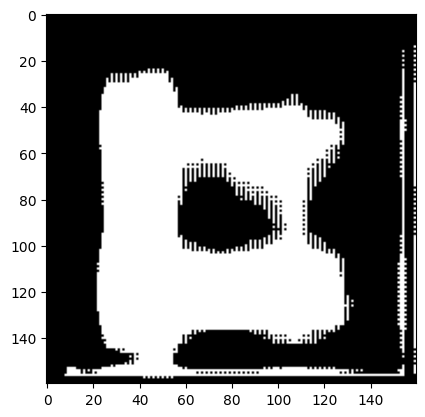

In [84]:
plt.imshow(binary_mask, cmap='gray')